In [7]:
# %pip install fast_pagerank

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from fast_pagerank import pagerank_power
import igraph as ig

In [2]:
import config
from data_loader import *

In [81]:
import os
import powerlaw
import numpy as np
import pandas as pd
import networkx as nx
from joblib import delayed
from joblib import Parallel
from collections import Counter
from fast_pagerank import pagerank_power

import matplotlib.pyplot as plt

In [41]:
import random

In [114]:
BIGNET = 11000
EXT = '.gpickle'
TOPK = 10

In [111]:
def _ppr(node_index, A, p, top):
    pp = np.zeros(A.shape[0])
    pp[node_index] = A.shape[0]
    pr = pagerank_power(A, p=p, personalize=pp)
    pr = pr.argsort()[-top-1:][::-1]
    #time.sleep(0.01)
    return pr[pr!=node_index][:top]

def get_circle_of_trust_per_node(A, p=0.85, top=10, num_cores=40):
    return Parallel(n_jobs=num_cores)(delayed(_ppr)(node_index, A, p, top) for node_index in np.arange(A.shape[0]))

def frequency_by_circle_of_trust(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    results = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    del(results)
    return [ 0 if node_index not in unique_elements else counts_elements[np.argwhere(unique_elements == node_index)[0, 0]] for node_index in np.arange(A.shape[0])]

def _salsa(node_index, cot, A, top=10):
    BG = nx.Graph()
    BG.add_nodes_from(['h{}'.format(vi) for vi in cot], bipartite=0)  # hubs
    edges = [('h{}'.format(vi), int(vj)) for vi in cot for vj in np.argwhere(A[vi,:] != 0 )[:,1]]
    BG.add_nodes_from(set([e[1] for e in edges]), bipartite=1)  # authorities
    BG.add_edges_from(edges)
    centrality = Counter({n: c for n, c in nx.eigenvector_centrality_numpy(BG).items() if type(n) == int
                                                                                       and n not in cot
                                                                                       and n != node_index
                                                                                       and n not in np.argwhere(A[node_index,:] != 0 )[:,1] })
    del(BG)
    #time.sleep(0.01)
    return np.asarray([n for n, pev in centrality.most_common(top)])[:top]

def frequency_by_who_to_follow(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    cot_per_node = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    results = Parallel(n_jobs=num_cores)(delayed(_salsa)(node_index, cot, A, top) for node_index, cot in enumerate(cot_per_node))
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    del(results)
    return [0 if node_index not in unique_elements else counts_elements[np.argwhere(unique_elements == node_index)[0, 0]] for node_index in np.arange(A.shape[0])]

def frequency_by_who_to_follow2(A, cot_per_node=None, p=0.85, top=10, num_cores=40):
    cot_per_node = cot_per_node if cot_per_node is not None else get_circle_of_trust_per_node(A, p, top, num_cores)
    results = Parallel(n_jobs=num_cores)(delayed(_salsa)(node_index, cot, A, top) for node_index, cot in enumerate(cot_per_node))
    unique_elements, counts_elements = np.unique(np.concatenate(results), return_counts=True)
    # del(results)
    return results

def who_to_follow_rank(A, njobs=1):
    if A.shape[0] < BIGNET:
        return wtf_small(A, njobs)
    else:
        # TODO: implement optimal (or faster) solution for big net
        return wtf_small(A, njobs)
        
def wtf_small(A, njobs):
    # utils.printf('cot_per_node...')
    cot_per_node = get_circle_of_trust_per_node(A, p=0.85, top=TOPK, num_cores=njobs)

    # utils.printf('cot...')
    cot = frequency_by_circle_of_trust(A, cot_per_node=cot_per_node, p=0.85, top=TOPK, num_cores=njobs)

    # utils.printf('wtf...')
    wtf = frequency_by_who_to_follow2(A, cot_per_node=cot_per_node, p=0.85, top=TOPK, num_cores=njobs)
    return wtf

In [152]:
g = read_pkl_graph("blogs_attributed_network_anon.gpickle")

In [169]:
bba = nx.scale_free_graph(3000)

In [177]:
cave = nx.connected_caveman_graph(l=10, k=100)

In [145]:
network82 = nx.read_gpickle(config.ROOT + 'nx_DPAH_10000_0208_0802.pkl')

In [178]:
wtf = who_to_follow_rank(A=nx.adjacency_matrix(cave))

In [ ]:
recomm_dict = {}

for node in cave.nodes():
    r = twitter_wtf(network=cave, sparse_adj=nx.adjacency_matrix(cave), node_id=node, 
                    k_for_recommendation=-1, k_for_circle_of_trust=10)
    
    if len(r) > 0:
        recomm_dict[node] = r[0]
dists = [abs(tup[-1]-tup[0]) for tup in recomm_dict.values()]

In [179]:
pick = [random.choice(list(x)) if len(x) > 0 else 'skip' for x in wtf]

In [180]:
Counter(pick)['skip']

10

In [173]:
nodes = list(bba.nodes())

In [174]:
zz = dict(zip(nodes, pick))

In [175]:
dists = [abs(key-val) for key, val in zz.items()]

In [176]:
np.average(dists)

1372.541

In [94]:
cns = [len(list(nx.common_neighbors(cavemen, key, val))) for key, val in zz.items() if val in cavemen_nodes]

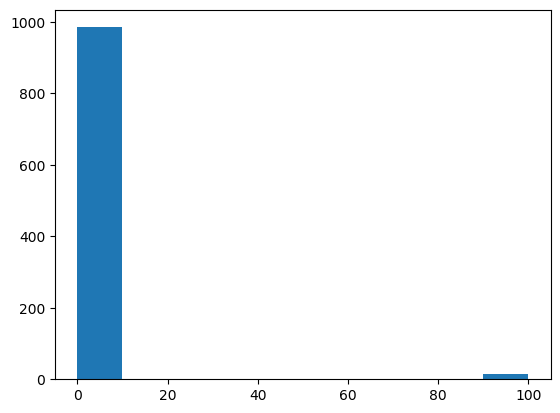

In [95]:
plt.hist(cns, bins=10)
plt.show()

In [14]:
g = read_pkl_graph("blogs_attributed_network_anon.gpickle")

In [93]:
def twitter_wtf(network, sparse_adj, node_id, k_for_circle_of_trust=20, cot_factor= 0.05, tol=1e-8,
                damping_factor=.85, k_for_recommendation=-1):
    """This method aims to realize a link prediction algorithm used by Twitter to perform
        the WTF recommendation on the platform.
        The algorithm can be seen at 'https://web.stanford.edu/~rezab/papers/wtf_overview.pdf'.
        The algorithm consists of two phases:
            1) Compute the circle of trust for the user you want to recommend(top-k nodes in PPR)
            2) Compute the top-k nodes using score propagation
    """
    k_for_circle_of_trust = int(network.number_of_nodes()*cot_factor)
    # k_for_circle_of_trust = 30
    #1st phase: Compute circle of trust of user according to Personalized PageRank
    personalize = np.zeros(shape=network.number_of_nodes())
    personalize[node_id] = 1
    values_of_personalized_pr = pagerank_power(sparse_adj, p=damping_factor, personalize=personalize, tol=1e-6)
    circle_of_trust = values_of_personalized_pr.argsort()[-k_for_circle_of_trust:][::-1]

    #2nd phase: init bipartite graph
    bipartite_graph = nx.DiGraph()
    #add nodes belonging to the circle of trust as hubs(H)
    for node in circle_of_trust:
        #these nodes are "hubs"(H) in the bipartite graph
        bipartite_graph.add_node(str(node)+"H")
    #add out neighbors of nodes belonging to the circle of trust as authorities(A)
    for node in circle_of_trust:
        for out_neighbor in network.neighbors(node):
            #direction is inverted for a matter of simplicity in the sequent phases
            bipartite_graph.add_edge(str(out_neighbor)+"A", str(node)+"H")

    #retrieve adjacency matrix of bipartite graph
    A = nx.to_numpy_array(bipartite_graph)

    #retrieve list of all nodes splitted by authority or hub
    all_nodes = list(bipartite_graph.nodes())
    hub_nodes = [int(x[:-1]) for x in all_nodes if 'H' in x]
    authority_nodes = [int(x[:-1]) for x in all_nodes if 'A' in x]

    #3rd phase: start building ingredients of our SALSA algorithm
    #these are the transition matrices determined by the bipartite graph
    S_prime = A[len(hub_nodes):, :][:, :len(hub_nodes)].copy()
    R_prime = S_prime.T.copy()
    #normalize both matrices
    denominator_S_prime = S_prime.sum(axis=0)
    denominator_S_prime[denominator_S_prime == 0] = 1
    S_prime = S_prime / denominator_S_prime
    denominator_R_prime = R_prime.sum(axis=0)
    denominator_R_prime[denominator_R_prime == 0] = 1
    R_prime = R_prime / denominator_R_prime
    #these are the vectors which contain the score of similarity
    #and relevance
    s = np.zeros(shape=(len(hub_nodes), 1), dtype=np.float)
    r = np.zeros(shape=(len(authority_nodes), 1), dtype=np.float)

    #at the beginning of the procedure we put the similarity
    #of the user we want to give the recommendation equal to 1
    index_of_node_to_recommend = np.where(circle_of_trust == node_id)[0][0]
    s[index_of_node_to_recommend] = 1.

    #init damping vector
    alpha = 1 - damping_factor
    alpha_vector = np.zeros(shape=(len(hub_nodes), 1), dtype=np.float)
    alpha_vector[index_of_node_to_recommend] = alpha

    #4th phase: run the algorithm
    convergence = False
    while not convergence:
        s_ = s.copy()
        r_ = r.copy()
        r_ = S_prime.dot(s)
        s_ = alpha_vector + (1 - alpha)*(R_prime.dot(r))
        #compute difference and check if convergence has been reached
        diff = abs(s_ - s)
        if np.linalg.norm(diff) < tol:
            convergence=True
        #update real vectors
        s = s_
        r = r_

    #5th phase: order by score and delete neighbors of node to be recommended
    #of course we don't want to recommend people that the user already follow
    neighbors_to_not_recommend = nx.neighbors(network, node_id)
    relevance_scores = r.flatten()
    if k_for_recommendation == -1:
        k_for_recommendation = 0 #Take all the nodes!

    neighbors_to_not_recommend = set(neighbors_to_not_recommend)
    results = []
    for node in relevance_scores.argsort()[::-1]:
        if node not in neighbors_to_not_recommend and node != node_id:
            results.append(((node_id, node)))
            if len(results) == k_for_recommendation:
                break
    return results

In [181]:
r = twitter_wtf(test, nx.adjacency_matrix(test), 4, k_for_recommendation=-1)

In [184]:
l = []
l.append(r)

In [185]:
l

[[(4, 1),
  (4, 0),
  (4, 2),
  (4, 3),
  (4, 39),
  (4, 224),
  (4, 100),
  (4, 95),
  (4, 474),
  (4, 464),
  (4, 159),
  (4, 780),
  (4, 401),
  (4, 86),
  (4, 429),
  (4, 612),
  (4, 792),
  (4, 80),
  (4, 356),
  (4, 198),
  (4, 83),
  (4, 82),
  (4, 148),
  (4, 2652),
  (4, 1751),
  (4, 144),
  (4, 2291),
  (4, 81),
  (4, 2653),
  (4, 1418),
  (4, 1885),
  (4, 79),
  (4, 2498),
  (4, 255),
  (4, 345),
  (4, 216),
  (4, 71),
  (4, 1988),
  (4, 160),
  (4, 2651),
  (4, 2654),
  (4, 84),
  (4, 97),
  (4, 164),
  (4, 6),
  (4, 115),
  (4, 421),
  (4, 428),
  (4, 2628),
  (4, 25),
  (4, 29),
  (4, 138),
  (4, 59),
  (4, 1130),
  (4, 722),
  (4, 1498),
  (4, 326),
  (4, 2216),
  (4, 622),
  (4, 1239),
  (4, 38),
  (4, 370),
  (4, 1005),
  (4, 760),
  (4, 2215),
  (4, 2217),
  (4, 2218),
  (4, 467),
  (4, 641),
  (4, 65),
  (4, 794),
  (4, 945),
  (4, 167),
  (4, 68),
  (4, 134),
  (4, 930),
  (4, 599),
  (4, 425),
  (4, 774),
  (4, 135),
  (4, 577),
  (4, 103),
  (4, 946),
  (4, 591),


In [31]:
top_10pct = r[: int(len(r)*0.1)]

In [33]:
cls = [test.nodes()[edge[1]]['m'] for edge in top_10pct]

In [37]:
cls

[0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
x =  {'a': 0,
'b':0}

In [39]:
for i in range(5):

    if i % 2 == 0:
        x['a']+=1
    else:
        x['b']+=1

In [46]:
b = np.array([])

In [56]:
import sys

In [3]:
b=10

In [9]:
x = 'ajjaa.pkl'

x[:-4] + '.txt'

'ajjaa.txt'

In [3]:
with open('outfile.txt', 'w') as sys.stdout:
    print("hihi")
    print("----------")
    print(f"{x}")
    sys.stdout.close() 

In [5]:
f = open('test.txt', 'w')
f.write('lalalala\n')
f.write('yoyooyoy\n')
f.write(f'{b}\n')

f.close()

In [ ]:
b.append(5)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [13]:
test = read_pkl_graph('nx_DPAH_10000_0208_0505.pkl')
nodes = list(set(list(test.nodes())))

In [37]:
old = list(blogs.nodes())
new = list(range(0, 1224))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [38]:
personalize = np.zeros(shape=g.number_of_nodes())
personalize[0] = 1

In [39]:
personalize[0:10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])